<a href="https://colab.research.google.com/github/Reyhan-Code/DeteksiJamur/blob/main/jamur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import gdown
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [2]:
# Ganti dengan ID file Anda
file_id = '1cuWi7hrabxAd4jNv8sXIMcHIgi4pZgog'
url = f'https://drive.google.com/uc?id={file_id}'

# Lokasi tempat menyimpan file zip yang diunduh
zip_path = '/content/mushroom_datasets.zip'

# Mengunduh file
gdown.download(url, zip_path, quiet=False)

# Ekstrak file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/my_folder')

Downloading...
From (original): https://drive.google.com/uc?id=1cuWi7hrabxAd4jNv8sXIMcHIgi4pZgog
From (redirected): https://drive.google.com/uc?id=1cuWi7hrabxAd4jNv8sXIMcHIgi4pZgog&confirm=t&uuid=f0548ef7-a467-420a-8da4-7a2760395278
To: /content/mushroom_datasets.zip
100%|██████████| 518M/518M [00:04<00:00, 108MB/s] 


In [17]:
base_dir = '/content/my_folder/mushroom_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

edible_classes = [
    'Agaricus augustus', 'Amanita amerirubescens', 'Amanita calyptroderma', 'Armillaria mellea',
    'Armillaria tabescens', 'Artomyces pyxidatus', 'Bolbitius titubans', 'Boletus pallidus',
    'Boletus rex-veris', 'Cantharellus californicus', 'Cantharellus cinnabarinus', 'Cerioporus squamosus',
    'Chlorophyllum brunneum', 'Clitocybe nuda', 'Coprinellus micaceus', 'Coprinus comatus',
    'Entoloma abortivum', 'Flammulina velutipes', 'Ganoderma applanatum', 'Ganoderma oregonense'
]

non_edible_classes = [
    'Coprinopsis lagopus', 'Crucibulum laeve', 'Cryptoporus volvatus', 'Fomitopsis mounceae',
    'Ganoderma curtisii', 'Ganoderma tsugae', 'Gliophorus psittacinus', 'Gloeophyllum sepiarium',
    'Gymnopilus luteofolius', 'Hypholoma lateritium', 'Leucoagaricus americanus', 'Leucoagaricus leucothites',
    'Lycogala epidendrum', 'Mycena leaiana', 'Panellus stipticus', 'Phaeolus schweinitzii',
    'Phyllotopsis nidulans', 'Psilocybe caerulescens', 'Psilocybe cubensis', 'Schizophyllum commune'
]


def get_edibility_label(class_name):
    if class_name in edible_classes:
        return 0  # Edible
    elif class_name in non_edible_classes:
        return 1  # Non-edible
    else:
        raise ValueError(f"Unknown class name: {class_name}")

In [4]:
# Menggunakan InceptionV3 sebagai base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = True

# Freeze sampai layer tertentu
fine_tune_at = 100  # Anda bisa menyesuaikan ini
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.5)(x)  # Dropout layer with 50% rate
mushroom_class_output = Dense(len(edible_classes) + len(non_edible_classes), activation='softmax', name='mushroom_class_output')(x)
edibility_output = Dense(2, activation='softmax', name='edibility_output')(x)

model = Model(inputs=base_model.input, outputs=[mushroom_class_output, edibility_output])

# Menyesuaikan Learning Rate Optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate
              loss={'mushroom_class_output': 'categorical_crossentropy', 'edibility_output': 'categorical_crossentropy'},
              metrics={'mushroom_class_output': 'accuracy', 'edibility_output': 'accuracy'})

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [5]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=64,  # Batch size lebih besar
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=64,  # Batch size lebih besar
    class_mode='categorical',
    shuffle=False
)

def custom_generator(generator):
    class_indices = generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}

    while True:
        x, y = generator.next()
        batch_size = x.shape[0]
        edibility_labels = np.array([get_edibility_label(index_to_class[np.argmax(y[i])])
                                     for i in range(batch_size)])
        edibility_labels = tf.keras.utils.to_categorical(edibility_labels, num_classes=2)
        yield x, {'edibility_output': edibility_labels, 'mushroom_class_output': y}

train_generator_custom = custom_generator(train_generator)
validation_generator_custom = custom_generator(validation_generator)

Found 6000 images belonging to 40 classes.
Found 1200 images belonging to 40 classes.


In [7]:
history = model.fit(
    train_generator_custom,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,
    validation_data=validation_generator_custom,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/2
93/93 [==============================] - 211s 2s/step - loss: 4.0204 - mushroom_class_output_loss: 3.1975 - edibility_output_loss: 0.8229 - mushroom_class_output_accuracy: 0.2353 - edibility_output_accuracy: 0.6664 - val_loss: 2.7365 - val_mushroom_class_output_loss: 2.2527 - val_edibility_output_loss: 0.4838 - val_mushroom_class_output_accuracy: 0.4887 - val_edibility_output_accuracy: 0.7786
Epoch 2/2
93/93 [==============================] - 198s 2s/step - loss: 2.1326 - mushroom_class_output_loss: 1.5863 - edibility_output_loss: 0.5464 - mushroom_class_output_accuracy: 0.5487 - edibility_output_accuracy: 0.7699 - val_loss: 1.6384 - val_mushroom_class_output_loss: 1.2289 - val_edibility_output_loss: 0.4096 - val_mushroom_class_output_accuracy: 0.7257 - val_edibility_output_accuracy: 0.8073


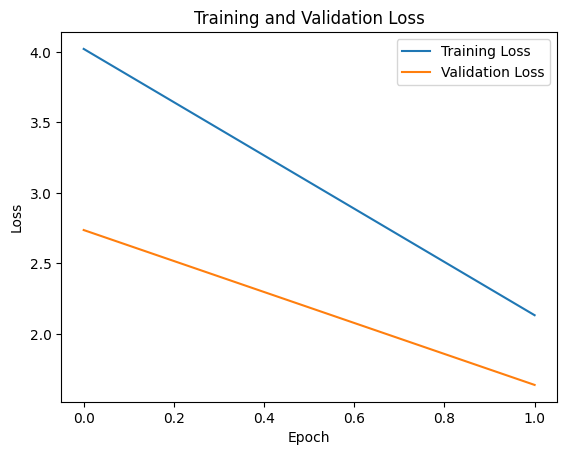

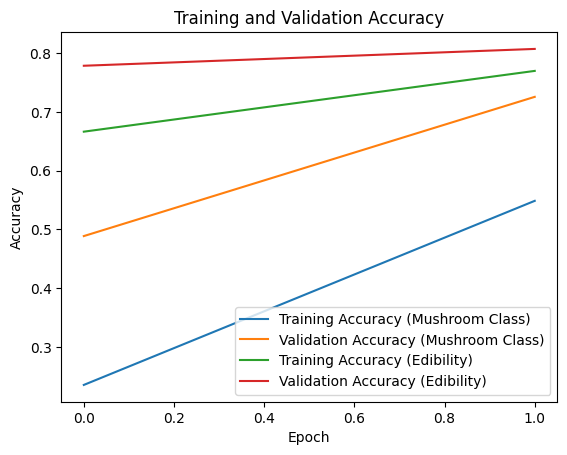

In [8]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['mushroom_class_output_accuracy'], label='Training Accuracy (Mushroom Class)')
    plt.plot(history.history['val_mushroom_class_output_accuracy'], label='Validation Accuracy (Mushroom Class)')
    plt.plot(history.history['edibility_output_accuracy'], label='Training Accuracy (Edibility)')
    plt.plot(history.history['val_edibility_output_accuracy'], label='Validation Accuracy (Edibility)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

In [9]:
# Evaluasi model
loss, mushroom_class_output_loss, edibility_output_loss, mushroom_class_output_accuracy, edibility_output_accuracy = model.evaluate(
    validation_generator_custom,
    steps=validation_generator.samples // validation_generator.batch_size
)

print(f"Validation loss: {loss}")
print(f"Validation mushroom class output loss: {mushroom_class_output_loss}")
print(f"Validation edibility output loss: {edibility_output_loss}")
print(f"Validation mushroom class output accuracy: {mushroom_class_output_accuracy}")
print(f"Validation edibility output accuracy: {edibility_output_accuracy}")

18/18 [==============================] - 14s 789ms/step - loss: 1.6384 - mushroom_class_output_loss: 1.2289 - edibility_output_loss: 0.4096 - mushroom_class_output_accuracy: 0.7257 - edibility_output_accuracy: 0.8073
Validation loss: 1.6384472846984863
Validation mushroom class output loss: 1.2288583517074585
Validation edibility output loss: 0.4095887541770935
Validation mushroom class output accuracy: 0.7256944179534912
Validation edibility output accuracy: 0.8072916865348816


In [10]:
# Evaluasi Metrik Lainnya
y_true_class = []
y_true_edibility = []
y_pred_class = []
y_pred_edibility = []

validation_generator.reset()
for _ in range(validation_generator.samples // validation_generator.batch_size):
    x, y = next(validation_generator_custom)
    y_true_class.extend(np.argmax(y['mushroom_class_output'], axis=1))
    y_true_edibility.extend(np.argmax(y['edibility_output'], axis=1))
    predictions = model.predict(x)
    y_pred_class.extend(np.argmax(predictions[0], axis=1))
    y_pred_edibility.extend(np.argmax(predictions[1], axis=1))

# Evaluasi untuk klasifikasi jenis jamur
precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(y_true_class, y_pred_class, average='macro')
accuracy_class = accuracy_score(y_true_class, y_pred_class)

print("Metrik untuk klasifikasi jenis jamur:")
print(f'Precision: {precision_class}')
print(f'Recall: {recall_class}')
print(f'F1 Score: {f1_class}')
print(f'Accuracy: {accuracy_class}')

# Evaluasi untuk klasifikasi edibility
precision_edibility, recall_edibility, f1_edibility, _ = precision_recall_fscore_support(y_true_edibility, y_pred_edibility, average='macro')
accuracy_edibility = accuracy_score(y_true_edibility, y_pred_edibility)

print("Metrik untuk klasifikasi edibility:")
print(f'Precision: {precision_edibility}')
print(f'Recall: {recall_edibility}')
print(f'F1 Score: {f1_edibility}')
print(f'Accuracy: {accuracy_edibility}')


2/2 [==============================] - 0s 128ms/step
Metrik untuk klasifikasi jenis jamur:
Precision: 0.7389998029990491
Recall: 0.7054166666666666
F1 Score: 0.6985225441050228
Accuracy: 0.7256944444444444
Metrik untuk klasifikasi edibility:
Precision: 0.8363199654558213
Recall: 0.8010144927536231
F1 Score: 0.8005365944967866
Accuracy: 0.8072916666666666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
model.save('/content/my_folder/model.keras')
print("Model Keras disimpan sebagai model.keras")

model = tf.keras.models.load_model('/content/my_folder/model.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/my_folder/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model TFLite disimpan sebagai model.tflite")

Model Keras disimpan sebagai model.keras
Model TFLite disimpan sebagai model.tflite


In [12]:
# Fungsi untuk memuat gambar
def load_image(image_path, target_size=(299, 299)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img).astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Fungsi untuk prediksi gambar
def predict_image(model_path, image_path, edible_class_names, non_edible_class_names):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = load_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    class_output = interpreter.get_tensor(output_details[0]['index'])
    edibility_output = interpreter.get_tensor(output_details[1]['index'])

    edibility_index = np.argmax(edibility_output)
    edibility = 'Edible' if edibility_index == 0 else 'Non-Edible'

    class_index = np.argmax(class_output)

    print(f"Predicted class index: {class_index}, Edibility index: {edibility_index}")

    if edibility == 'Edible':
        if class_index < len(edible_class_names):
            mushroom_class = edible_class_names[class_index]
        else:
            mushroom_class = "Unknown edible class"
    else:
        if class_index < len(non_edible_class_names):
            mushroom_class = non_edible_class_names[class_index]
        else:
            mushroom_class = "Unknown non-edible class"

    return mushroom_class, edibility

# Fungsi untuk mengunggah dan memprediksi gambar
def upload_and_predict():
    uploaded = files.upload()

    for fn in uploaded.keys():
        path = '/content/' + fn
        mushroom_class, edibility = predict_image('/content/my_folder/model.tflite', path, edible_classes, non_edible_classes)
        print(f'{fn} is classified as {mushroom_class} ({edibility})')

upload_and_predict()


Saving WhatsApp Image 2024-06-11 at 17.38.37_1430b85e.jpg to WhatsApp Image 2024-06-11 at 17.38.37_1430b85e.jpg
Predicted class index: 0, Edibility index: 0
WhatsApp Image 2024-06-11 at 17.38.37_1430b85e.jpg is classified as Agaricus augustus (Edible)


In [13]:
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 21.9 MB/s eta 0:00:00


In [19]:
# Daftar kelas jamur yang bisa dimakan
edible_classes = [
    'Agaricus augustus', 'Amanita amerirubescens', 'Amanita calyptroderma', 'Armillaria mellea',
    'Armillaria tabescens', 'Artomyces pyxidatus', 'Bolbitius titubans', 'Boletus pallidus',
    'Boletus rex-veris', 'Cantharellus californicus', 'Cantharellus cinnabarinus', 'Cerioporus squamosus',
    'Chlorophyllum brunneum', 'Clitocybe nuda', 'Coprinellus micaceus', 'Coprinus comatus',
    'Entoloma abortivum', 'Flammulina velutipes', 'Ganoderma applanatum', 'Ganoderma oregonense'
]

# Daftar kelas jamur yang tidak bisa dimakan
non_edible_classes = [
    'Coprinopsis lagopus', 'Crucibulum laeve', 'Cryptoporus volvatus', 'Fomitopsis mounceae',
    'Ganoderma curtisii', 'Ganoderma tsugae', 'Gliophorus psittacinus', 'Gloeophyllum sepiarium',
    'Gymnopilus luteofolius', 'Hypholoma lateritium', 'Leucoagaricus americanus', 'Leucoagaricus leucothites',
    'Lycogala epidendrum', 'Mycena leaiana', 'Panellus stipticus', 'Phaeolus schweinitzii',
    'Phyllotopsis nidulans', 'Psilocybe caerulescens', 'Psilocybe cubensis', 'Schizophyllum commune'
]

# Gabungkan kedua daftar
all_classes = edible_classes + non_edible_classes

# Tulis daftar kelas ke file labels.txt
label_file_path = "labels.txt"
with open(label_file_path, "w") as f:
    for cls in all_classes:
        f.write(cls + "\n")

# Verifikasi isi file
with open(label_file_path, "r") as f:
    print(f.read())

Agaricus augustus
Amanita amerirubescens
Amanita calyptroderma
Armillaria mellea
Armillaria tabescens
Artomyces pyxidatus
Bolbitius titubans
Boletus pallidus
Boletus rex-veris
Cantharellus californicus
Cantharellus cinnabarinus
Cerioporus squamosus
Chlorophyllum brunneum
Clitocybe nuda
Coprinellus micaceus
Coprinus comatus
Entoloma abortivum
Flammulina velutipes
Ganoderma applanatum
Ganoderma oregonense
Coprinopsis lagopus
Crucibulum laeve
Cryptoporus volvatus
Fomitopsis mounceae
Ganoderma curtisii
Ganoderma tsugae
Gliophorus psittacinus
Gloeophyllum sepiarium
Gymnopilus luteofolius
Hypholoma lateritium
Leucoagaricus americanus
Leucoagaricus leucothites
Lycogala epidendrum
Mycena leaiana
Panellus stipticus
Phaeolus schweinitzii
Phyllotopsis nidulans
Psilocybe caerulescens
Psilocybe cubensis
Schizophyllum commune



In [20]:
from google.colab import files

# Unduh file labels.txt
files.download(label_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
!pip install --upgrade pip
!pip install --upgrade tensorflow
!pip install --upgrade tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5p

In [24]:
import tensorflow as tf
from tflite_support.metadata_writers import writer_utils
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import metadata_writer_for_image_classifier

# Path to the TFLite model file
model_path = "model.tflite"
# Path to save the TFLite model with metadata
output_model_path = "model_with_metadata.tflite"
# Label file path
label_file_path = "labels.txt"

# Create an instance of the metadata writer for image classifier
writer = metadata_writer_for_image_classifier.MetadataWriter.create_for_inference(
    model_buffer=writer_utils.load_file(model_path),
    input_norm_mean=[127.5],
    input_norm_std=[127.5],
    label_file_paths=[label_file_path]
)

# Populate the metadata into the model
with open(output_model_path, "wb") as f:
    f.write(writer.populate())

2024-06-13 12:18:00.369129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 12:18:00.369204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 12:18:00.370938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 12:18:01.966088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/metadata_writer_for_image_classifier.py", line 29, in <module>
    from tflite_support import metadata_schema_py_generated as _metadata_fb
  File "/usr/local/lib/python3.10/dist-packages/tf